 Project - Sentiment Analysis 

PART 2 - MODELLING

In [1]:
'''Import Libraries'''
import numpy as np
import pandas as pd 
from numpy import concatenate
import matplotlib.pyplot as plt
%matplotlib inline

#Libraries for machine learning
from sklearn import metrics
from sklearn.semi_supervised import LabelPropagation
from sklearn.semi_supervised import SelfTrainingClassifier
from sklearn.metrics import accuracy_score,precision_score, recall_score,f1_score
from sklearn.model_selection import train_test_split            
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import TruncatedSVD
import warnings
warnings.filterwarnings('ignore')
pd.options.mode.chained_assignment = None  


In [2]:
'''Import Libraries for Text Analytics'''
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import string

import re
import neattext as nt
import neattext.functions as nfx

from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy

Load and prepare data for Modelling

In [3]:
'''Load the labelled dataset'''

data_labelled=pd.read_csv('./labelled.csv')
#create dataframe with only reviews and sentiment 
df_labelled =  data_labelled.drop(['Unnamed: 0'], axis =1)

Data Preprocessing

Expand Contractions

In [4]:
# create a dictionary with expanded contractions
contractions_dict = { 
"ain't": "has not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have", "'cause": "because", "could've": "could have",
"couldn't": "could not", "couldn't've": "could not have", "didn't": "did not", "doesn't": "does not", "don't": "do not",
"hadn't": "had not", "hadn't've": "had not have", "hasn't": "has not", "haven't": "have not", "he'd": "he would",
"he'd've": "he would have", "he'll": "he will", "he'll've": "he will have", "he's": "he is", "how'd": "how did",
"how'd'y": "how do you", "how'll": "how will", "how's": "how is", "I'd": "I would", "I'd've": "I would have",
"I'll": "I will", "I'll've": "I will have", "I'm": "I am", "I've": "I have", "isn't": "is not",
"it'd": "it would", "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have",
"it's": "it is", "let's": "let us", "ma'am": "madam","mayn't": "may not","might've": "might have",
"mightn't": "might not", "mightn't've": "might not have", "must've": "must have",
"mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have",
"o'clock": "of the clock","oughtn't": "ought not","oughtn't've": "ought not have",
"shan't": "shall not","sha'n't": "shall not","shan't've": "shall not have","she'd": "she would",
"she'd've": "she would have","she'll": "she will","she'll've": "she will have","she's": "she is",
"should've": "should have","shouldn't": "should not","shouldn't've": "should not have","so've": "so have",
"so's": "so is","that'd": "that would","that'd've": "that would have","that's": "that is","there'd": "there would",
"there'd've": "there would have","there's": "there is","they'd": "they would","they'd've": "they would have",
"they'll": "they will","they'll've": "they will have","they're": "they are","they've": "they have",
"to've": "to have","wasn't": "was not","we'd": "we would","we'd've": "we would have","we'll": "we will",
"we'll've": "we will have","we're": "we are","we've": "we have","weren't": "were not",
"what'll": "what shall / what will","what'll've": "what will have","what're": "what are",
"what's": "what is","what've": "what have","when's": "when is","when've": "when have","where'd": "where did",
"where's": "where is","where've": "where have","who'll": "who will","who'll've": "who will have","who's": "who is",
"who've": "who have","why's": "why is","why've": "why have","will've": "will have","won't": "will not",
"won't've": "will not have","would've": "would have","wouldn't": "would not","wouldn't've": "would not have",
"y'all": "you all","y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are",
"y'all've": "you all have","you'd": "you would","you'd've": "you would have","you'll": "you will",
"you'll've": "you will have","you're": "you are","you've": "you have"
}

contractions_re = re.compile('(%s)' % '|'.join(contractions_dict.keys()))

def expand_contractions(texts, contractions_dict=contractions_dict):
    '''Function to expand contractions
    Args: texts: text to expand contractions
    Returns  text with expanded contractions
    '''
    def replace(match):
        return contractions_dict[match.group(0)]
    return contractions_re.sub(replace, texts)

Stopwords Removal

In [5]:
'''Get stopwords and add custom stopwords to the list'''

#extract the stopwords from the review
lst_of_stopwords = df_labelled['Review'].astype('U').apply(lambda x:nt.TextExtractor(x).extract_stopwords())
#convert each list of lists to a single list
flat_list_stopwords = [item for sublist in lst_of_stopwords for item in sublist]

#create custom stopword list
custom_stopwords=['lol','hmm','ya','yay','awol','asap','ur','oh','na','ugh','wah','yucky','omg','im','id','aw','ive','lmao'\
                 'ye','wow','hey','urgh']
#join the stopword lists
all_stopwords_list=flat_list_stopwords  + custom_stopwords
set_of_stopwords=set(all_stopwords_list)

#remove negation words from stop word list                                                   
not_stopwords={'not','no','nobody','none','never','against','neither','nor','nothing','cannot'}
new_set_stopwords = set_of_stopwords - not_stopwords


def remove_stopwords(text):     
    '''Function to remove stopwords
    Args: texts: text to remove stopwords
    Returns  text with  stopwords removed
    '''
    new_text= " ".join([word for word in str(text).split() if word not in new_set_stopwords])
    return new_text

In [6]:
def clean_text(text):
    '''Function to remove link,user and special characters
    Args: texts: text to clean
    Returns  text with special characters removed
    '''
    removal_string = "@\S+|https?:\S+|http?:\S|[^A-Za-z0-9]+"
    text = re.sub(removal_string, ' ', str(text).lower()).strip()
    tokens = []
    #tokenize and clean text
    for token in text.split():
        if token not in new_set_stopwords:
            tokens.append(token)
    return " ".join(tokens)

In [7]:
#extract  meaningful words
words = set(nltk.corpus.words.words())
def clean_sent(sent):
    '''Function to remove meaningless and alphanumeric characters
    Args: sent: text to clean
    Returns  text with alphanumeric characters removed
    '''
    #tokenize and clean text
    return " ".join(w for w in nltk.word_tokenize(sent) \
         if w.lower() in words or not w.isalpha())

Normalization - Lemmatization

In [8]:
def lemmatize_text(words):
    '''Function for lemmatizing
     Args: words: text to lemmatize
     Returns lemmatized text
     '''
    wordnet_lemmatizer = WordNetLemmatizer()
    lemmatized_sentence = []
    tokens = word_tokenize(words)
    #tokenize and lemmatize text
    for token in tokens:
        lemmatized_word = wordnet_lemmatizer.lemmatize(token)
        lemmatized_sentence.append(lemmatized_word)
    return " ".join(lemmatized_sentence)

In [9]:
%%time
#Call the text preprocessing functions for preprocessing the reviews in the labelled dataset
#Expand contractions in the text
df_labelled.loc[:, ('Review_clean')]  = df_labelled['Review'].astype('U').apply(lambda text: expand_contractions(text))

#Remove stopwords from the text
df_labelled.loc[:, ('Review_clean')]  = df_labelled['Review_clean'].astype('U').apply(lambda text: remove_stopwords(text))

#Remove unwanted characters from the text
df_labelled.loc[:, ('Review_clean')] = df_labelled['Review_clean'].astype('U').apply(lambda text: clean_text(text))

#Extract meaningful words from the text
df_labelled.loc[:, ('Review_clean')] = df_labelled['Review_clean'].astype('U').apply(lambda text: clean_sent(text))

#Lemmatize the text
df_labelled.loc[:, ('Review_clean')] = df_labelled['Review_clean'].astype('U').apply(lambda text: lemmatize_text(text))

Wall time: 1min 35s


Tokenization and Vectorization

In [10]:
def tokenizer_text(text):
    '''Function for tokenizing text'''
    tokens = word_tokenize(text)
    return tokens

In [11]:
# Vectorization with TF-IDF for feature representation (Labelled data)

tfidf_vectorizer=TfidfVectorizer(tokenizer = tokenizer_text, min_df = 10, max_df=0.75)       #use_idf=True  , minimum occurence of terms in 10 documents 
tfidf_vectorizer.fit_transform(df_labelled['Review_clean'].values)

features_l=tfidf_vectorizer.transform(df_labelled['Review_clean'].values)
Y_labelled = np.copy(df_labelled.Sentiment)

Split Data to train set and test set

In [12]:
# Train-test split (30% test) - with vectorized features (labelled data)
X_train, X_test, y_train, y_test = train_test_split(
    features_l, np.array(Y_labelled) , 
    test_size=0.3, 
    random_state=1)

MODELLING

a. The base supervised model

In [13]:
%%time
'''Create a supervised model with Logistic Regression'''

#max_iter = 1000 iterations for the liblinear solver to converge

clf_LR = LogisticRegression(max_iter=1000,solver='liblinear')
clf_LR.fit(X_train,y_train)
y_test_pred=clf_LR.predict(X_test)

#Calculate performance on the test data
print("classification_report for Supervised Model\n")
print(classification_report(y_test, y_test_pred, target_names=['Negative', 'Positive']))
print("confusion_matrix \n")
print(confusion_matrix(y_test, y_test_pred, labels=[0, 1]))

#calculate F1 score, accuracy
f1_lr = f1_score(y_test, y_test_pred, average='weighted')
print("\nPerformance on test set:")
print("\nLogistic Regression Accuracy:",metrics.accuracy_score(y_test, y_test_pred))  # compute accuracy of the model
print("Logistic Regression F1-Score:",f1_lr)  


classification_report for Supervised Model

              precision    recall  f1-score   support

    Negative       0.84      0.95      0.89    120280
    Positive       0.71      0.41      0.52     37131

    accuracy                           0.82    157411
   macro avg       0.77      0.68      0.71    157411
weighted avg       0.81      0.82      0.80    157411

confusion_matrix 

[[114029   6251]
 [ 21801  15330]]

Performance on test set:

Logistic Regression Accuracy: 0.82179136146775
Logistic Regression F1-Score: 0.8036019567019012
Wall time: 2 s


b. The semi-supervised model

In [14]:
#Get data from the unlabelled dataset
'''Load the dataset'''

data_unlabelled=pd.read_csv('./unlabelled.csv')
data_unlabelled =  data_unlabelled.drop(['Unnamed: 0'], axis =1)

Text Preprocessing for unlabelled dataset

In [15]:
%%time
#Call the text preprocessing functions for preprocessing the reviews in the unlabelled dataset

#Expand contractions in the text
data_unlabelled.loc[:, ('Review_clean')]  = data_unlabelled['Review'].astype('U').apply(lambda text: expand_contractions(text))

#Remove stopwords from the text
data_unlabelled.loc[:, ('Review_clean')]  = data_unlabelled['Review_clean'].astype('U').apply(lambda text: remove_stopwords(text))

#Remove unwanted characters from the text
data_unlabelled.loc[:, ('Review_clean')] = data_unlabelled['Review_clean'].astype('U').apply(lambda text: clean_text(text))

#Extract meaningful words from the text
data_unlabelled.loc[:, ('Review_clean')] = data_unlabelled['Review_clean'].astype('U').apply(lambda text: clean_sent(text))

#Lemmatize the text
data_unlabelled.loc[:, ('Review_clean')] = data_unlabelled['Review_clean'].astype('U').apply(lambda text: lemmatize_text(text))

Wall time: 1min 34s


In [16]:
#Vectorize the text with TFIDF for building model - unlabelled data

tf=TfidfVectorizer(max_features=10,tokenizer = tokenizer_text, min_df = 10, max_df=0.75) #minimum occurence of terms in 10 documents 
text_tf= tf.fit_transform(data_unlabelled['Review_clean'].values)
#transform to dense
features_dense =  text_tf.toarray()
features_dense=features_dense.astype(dtype=np.int8)

In [17]:
#reduce dimensionality with TruncatedSVD for the labelled features
tsvd = TruncatedSVD(n_components=8)
X_sparse_tsvd = tsvd.fit(features_l).transform(features_l)
X_data=X_sparse_tsvd[:52000]        #get around 10% of labelled features as in unlabelled set
Y_label=Y_labelled[:52000]

#reduce dimensionality with TruncatedSVD for the unlabelled features
tsvd_ul = TruncatedSVD(n_components=8)
X_sparse_tsvd_ul = tsvd_ul.fit(features_dense).transform(features_dense)
X_data_ul=X_sparse_tsvd_ul[:52000]        #get same number of features as in unlabelled set - for reducing computation time

#Prepare Data for Label Propagation
unlabelled_points = np.copy(data_unlabelled.Sentiment)            #Get the sentiment label
#combine the labelled and unlabelled data
X_mixed = concatenate((X_data, X_data_ul))
y_mixed = concatenate((Y_label, unlabelled_points[:52000]))
X_mixed=X_mixed.astype(dtype=np.int8)

In [18]:
'''Load the real labels of the unlabelled dataset'''

df_real_unlabelled=pd.read_csv('./real_unlabelled.csv')
df_real_unlabelled =  df_real_unlabelled.drop(['Unnamed: 0'], axis =1)
Y_real_unlabelled = df_real_unlabelled['Sentiment'].to_numpy()       #convert to array of labels

Label Propagation

In [19]:
%%time

'''Build the Semi-supervised model with label propagation'''

# Propagate labels onto unlabeled data using the labeled data 
label_prop_model = LabelPropagation(kernel ='knn')       
label_prop_model.fit(X_mixed, y_mixed)          #Fit on 52000 unlabelled points

# predict the labels for the unlabeled datapoints
Y_pred_unlabelled = label_prop_model.predict(X_mixed) 
unlabelled_points = np.copy(data_unlabelled.Sentiment)            #Get the sentiment label
Y_pred_unlabelled=Y_pred_unlabelled[unlabelled_points]      #predict on all the unlabelled points  

print("Semi-supervised model with label propagation is created.")

Semi-supervised model with label propagation is created.
Wall time: 4min 22s


c. The semi-supervised model based on the selected supervised model (LogisticRegression)

In [20]:
%%time
'''Self Training Classifier with Logistic Regression as base estimator'''

# Initialise LogisticRegression model
LR = LogisticRegression()

# Input this initial LogisticRegression model into the self-training classifier for 
#building a semisupervised model based on LogisticRegression
self_training_model = SelfTrainingClassifier(LR)

#reduce dimensionality with TruncatedSVD for the labelled features
tsvd = TruncatedSVD(n_components=10)
X_sparse_tsvd = tsvd.fit(features_l).transform(features_l)

#combine the labelled and unlabelled data
X_mixed_Self = concatenate((X_sparse_tsvd, features_dense))
y_mixed_Self = concatenate((Y_labelled, unlabelled_points))
X_mixed_Self=X_mixed_Self.astype(dtype=np.int8)

# Train the model with the self-training classifier on the labelled data in the combined data 
self_training_model.fit(X_mixed_Self, y_mixed_Self)

print("Semi-supervised model with SelfTrainingClassifier (base estimator:Logisitic Regression) is created.")

Semi-supervised model with SelfTrainingClassifier (base estimator:Logisitic Regression) is created.
Wall time: 5.66 s


d. Compute the performance of the models on unlabelled data set and plot the performance scores for comparison

i) performance of supervised Logistic Regression model on unlabelled data

In [21]:
'''Predict the unlabelled data with Logistic Regression (Supervised Model) and evaluate'''

#Get unlabelled features for prediction
# Vectorization with TF-IDF for feature representation

features_unlabelled = tfidf_vectorizer.fit_transform(data_unlabelled['Review_clean'].values)
pr_features_unlabelled = features_unlabelled[:,:8647]    #for fitting to the logistic regression model

#Predict on unlabelled data with Logistic Regression classifier
y_test_unlabelled_pred=clf_LR.predict(pr_features_unlabelled)

#Performance Metrics
Acc_Supervised = round(metrics.accuracy_score(Y_real_unlabelled, y_test_unlabelled_pred),4)  # compute accuracy of the model
f1_Supervised = round(f1_score(Y_real_unlabelled, y_test_unlabelled_pred,average="weighted"),4) # compute f1-score of the model
recall_Supervised = round(recall_score(Y_real_unlabelled,y_test_unlabelled_pred,average="weighted"),4)  # compute recall of the model
precision_Supervised = round(precision_score(Y_real_unlabelled,y_test_unlabelled_pred,average="weighted"),4) # compute precision score of the model

print("Performance of supervised Logistic Regression model on unlabelled data:\n")
print(classification_report(Y_real_unlabelled, y_test_unlabelled_pred, target_names=['Negative', 'Positive']))
print("confusion_matrix \n")
print(confusion_matrix(Y_real_unlabelled, y_test_unlabelled_pred, labels=[0, 1]))

print("\n")
print("Logistic Regression Accuracy:   ", Acc_Supervised) 
print("Logistic Regression F1-Score:   ",f1_Supervised)  
print("Logistic Regression Precision:  ", precision_Supervised) 
print("Logistic Regression Recall:     ",recall_Supervised)  

Performance of supervised Logistic Regression model on unlabelled data:

              precision    recall  f1-score   support

    Negative       0.77      0.88      0.82    399913
    Positive       0.29      0.16      0.21    123960

    accuracy                           0.71    523873
   macro avg       0.53      0.52      0.51    523873
weighted avg       0.66      0.71      0.68    523873

confusion_matrix 

[[350178  49735]
 [103733  20227]]


Logistic Regression Accuracy:    0.7071
Logistic Regression F1-Score:    0.6755
Logistic Regression Precision:   0.6573
Logistic Regression Recall:      0.7071


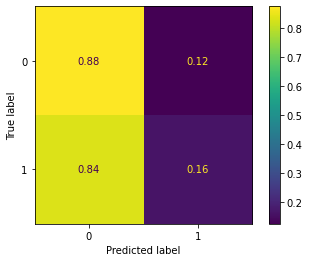

In [22]:
#Confusion Matrix for the supervised model - Logistic regression
cm = confusion_matrix(Y_real_unlabelled, y_test_unlabelled_pred, labels=clf_LR.classes_, normalize = 'true' )
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf_LR.classes_)
disp.plot()

ii) performance of semi-supervised model on unlabelled data

In [23]:
'''Performance Metrics - Label Propagation'''

#with the propagated labels and with the true labels

Acc_semiSupervised = round(metrics.accuracy_score(Y_real_unlabelled, Y_pred_unlabelled),4)

#Weighted scores
f1_semiSupervised = round(f1_score(Y_real_unlabelled, Y_pred_unlabelled,average="weighted"),4)
recall_semiSupervised = round(recall_score(Y_real_unlabelled,Y_pred_unlabelled,average="weighted"),4)
precision_semiSupervised = round(precision_score(Y_real_unlabelled,Y_pred_unlabelled,average="weighted"),4)

print("Performance of semi-supervised model (label propagation) on unlabelled data:\n")

print("Accuracy:   ", Acc_semiSupervised)       
print("Precision:  ", precision_semiSupervised)
print("Recall:     ", recall_semiSupervised)
print("F-score:    ", f1_semiSupervised)

Performance of semi-supervised model (label propagation) on unlabelled data:

Accuracy:    0.7634
Precision:   0.5827
Recall:      0.7634
F-score:     0.6609


In [24]:
#calculate with macro scores
Acc_semiSupervised_m = round(metrics.accuracy_score(Y_real_unlabelled, Y_pred_unlabelled),4)
f1_semiSupervised_macro = round(f1_score(Y_real_unlabelled, Y_pred_unlabelled,average="macro"),4)
recall_semiSupervised_macro = round(recall_score(Y_real_unlabelled,Y_pred_unlabelled,average="macro"),4)
precision_semiSupervised_macro = round(precision_score(Y_real_unlabelled,Y_pred_unlabelled,average="macro"),4)

print("Performance of semi-supervised model (label propagation) on unlabelled data (macro average):\n")

print("Accuracy:   ", Acc_semiSupervised_m)       
print("Precision:  ", precision_semiSupervised_macro)
print("Recall:     ", recall_semiSupervised_macro)
print("F-score:    ", f1_semiSupervised_macro)

Performance of semi-supervised model (label propagation) on unlabelled data (macro average):

Accuracy:    0.7634
Precision:   0.3817
Recall:      0.5
F-score:     0.4329


iii) performance of semi-supervised model based on Logistic Regression on unlabelled data

In [25]:
'''Predict the unlabelled data with the SelfTrainingClassifier  and evaluate''' 

#Predict
Y_pred_self=self_training_model.predict(X_mixed_Self)        
Y_pred_self=Y_pred_self[unlabelled_points]              #predict on all the unlabelled points               

#calculate weighted scores
Acc_semiSupervised_self = round(metrics.accuracy_score(Y_real_unlabelled, Y_pred_self),4)
f1_semiSupervised_self = round(f1_score(Y_real_unlabelled, Y_pred_self,average="weighted"),4)
recall_semiSupervised_self = round(recall_score(Y_real_unlabelled,Y_pred_self,average="weighted"),4)
precision_semiSupervised_self = round(precision_score(Y_real_unlabelled,Y_pred_self,average="weighted"),4)

#Performance metrics
print("Performance of self training classifier on unlabelled data\n")
print("Accuracy:  ", Acc_semiSupervised_self)
print("Precision: ", precision_semiSupervised_self)
print("Recall:    ", recall_semiSupervised_self)
print("F-score:   ", f1_semiSupervised_self)

Performance of self training classifier on unlabelled data

Accuracy:   0.7634
Precision:  0.5827
Recall:     0.7634
F-score:    0.6609


In [26]:
Acc_semiSupervised_self_m = round(metrics.accuracy_score(Y_real_unlabelled, Y_pred_self),4)

#calcualte macro average
f1_semiSupervised_self_macro = round(f1_score(Y_real_unlabelled, Y_pred_self,average="macro"),4)
recall_semiSupervised_self_macro = round(recall_score(Y_real_unlabelled,Y_pred_self,average="macro"),4)
precision_semiSupervised_self_macro = round(precision_score(Y_real_unlabelled,Y_pred_self,average="macro"),4)

#Performance metrics
print("Performance of self training classifier on unlabelled data (macro)\n")
print("Accuracy:  ", Acc_semiSupervised_self_m)
print("Precision: ", precision_semiSupervised_self_macro)
print("Recall:    ", recall_semiSupervised_self_macro)
print("F-score:   ", f1_semiSupervised_self_macro)

Performance of self training classifier on unlabelled data (macro)

Accuracy:   0.7634
Precision:  0.3817
Recall:     0.5
F-score:    0.4329


PLOT THE PERFORMANCE SCORES OF ALL MODELS

- SUPERVISED MODEL - LOGISITC REGRESSION (LR)
- SEMI SUPERVISED MODEL - with Label Propagation
- SELF TRAINED CLASSIFIER - with Logistic Regression (semi-supervised model based on the selected supervised model)

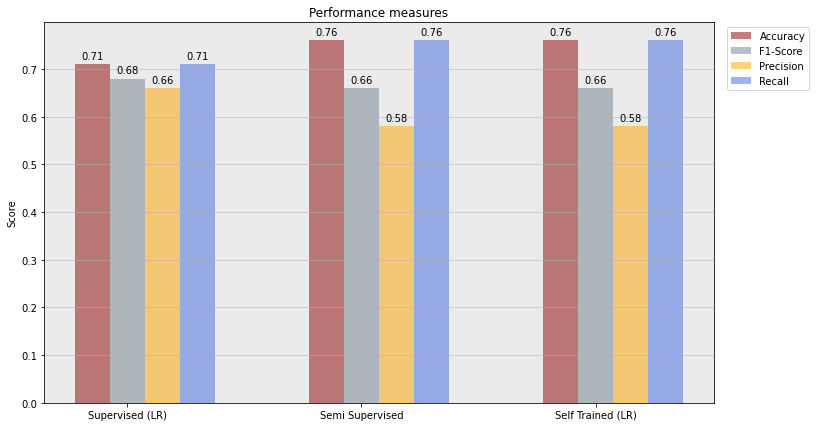

In [27]:
# function to add value labels to the bars 
def autolabel(rects):
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
         xy=(rect.get_x() + rect.get_width() / 2, height),
         xytext=(0, 3), 
         textcoords="offset points",
         ha='center', va='bottom')

#plot the three models for performance comparison

name_models = ('Supervised (LR)','Semi Supervised','Self Trained (LR)')
n_groups = 3
gps = np.arange( n_groups)
bar_width = 0.15

#round the scores for labelling and plotting
accuracy_values = [round(Acc_Supervised,2),round(Acc_semiSupervised,2),round(Acc_semiSupervised_self,2)]
f1_values = [round(f1_Supervised,2),round(f1_semiSupervised,2),round(f1_semiSupervised_self,2)]
precision_values = [round(precision_Supervised,2),round(precision_semiSupervised,2),round(precision_semiSupervised_self,2)]
recall_values = [round(recall_Supervised,2),round(recall_semiSupervised,2),round(recall_semiSupervised_self,2)]

fig, ax = plt.subplots(figsize=(12, 7))
ax.set_facecolor('#EBEBEB')

plt1 = plt.bar(gps, accuracy_values,  bar_width, alpha=0.5, color='darkred', label ='Accuracy')
plt2 = plt.bar(gps + bar_width , f1_values,  bar_width, alpha=0.5, color='slategrey', label ='F1-Score')
plt3 = plt.bar(gps + (2* bar_width), precision_values,  bar_width, alpha=0.5, color='orange', label ='Precision')
plt4 = plt.bar(gps + (3* bar_width), recall_values, bar_width, alpha=0.5, color='royalblue',  label ='Recall')

autolabel(plt1)
autolabel(plt2)
autolabel(plt3)
autolabel(plt4)

plt.xticks(gps  + bar_width, name_models)
plt.ylabel('Score')
plt.title('Performance measures')
plt.grid(axis = 'y', linewidth=0.5)
plt.legend(bbox_to_anchor= (1.15, 1))
plt.show()